In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from collections import Counter
import random
import torch.nn.functional as F

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)

In [25]:
dataset = load_dataset("CohleM/english-to-nepali")

In [26]:
subset = dataset['train'].shuffle(seed=SEED).select(range(10000)) 

train_val = subset.train_test_split(test_size=0.2, seed=SEED)
train_data, val_data = train_val['train'], train_val['test']

In [27]:
first = train_data[0]

ne_key = next(k for k in first.keys() if 'ne' in k.lower())
en_key = next(k for k in first.keys() if 'en' in k.lower())

In [28]:
class SimpleVocab:
    def __init__(self, counter, min_freq=2):
        self.itos = ['<unk>', '<pad>', '<sos>', '<eos>'] + [w for w, c in counter.items() if c >= min_freq]
        self.stoi = {w: i for i, w in enumerate(self.itos)}
    def __len__(self): return len(self.itos)
    def encode(self, tokens):
        return [self.stoi.get(tok, 0) for tok in tokens]

In [29]:
# Basic splitting for tokenization
def tokenize(text): return text.lower().split()

In [30]:
ne_counter, en_counter = Counter(), Counter()
for s in train_data:
    ne_counter.update(tokenize(s[ne_key]))
    en_counter.update(tokenize(s[en_key]))

ne_vocab = SimpleVocab(ne_counter)
en_vocab = SimpleVocab(en_counter)

In [52]:
torch.save(en_vocab, "en_vocab.pt")
torch.save(ne_vocab, "ne_vocab.pt")

In [31]:
def collate_fn(batch):
    src_list, trg_list = [], []
    for s in batch:
        src_tokens = [2] + en_vocab.encode(tokenize(s[en_key])) + [3] # English is now Source
        trg_tokens = [2] + ne_vocab.encode(tokenize(s[ne_key])) + [3] # Nepali is now Target
        src_list.append(torch.tensor(src_tokens))
        trg_list.append(torch.tensor(trg_tokens))
    
    # Pad sequences: [seq_len, batch_size]
    return (nn.utils.rnn.pad_sequence(src_list, padding_value=1), 
            nn.utils.rnn.pad_sequence(trg_list, padding_value=1))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=collate_fn)

## TASK 2

In [32]:
import torch.nn as nn
import torch.nn.functional as F
import random

In [33]:
class Attention(nn.Module):
    def __init__(self, hid_dim, attn_type='additive'):
        super().__init__()
        self.attn_type = attn_type
        if attn_type == 'additive':
            self.W = nn.Linear(hid_dim * 3, hid_dim)
            self.v = nn.Linear(hid_dim, 1, bias=False)
        else: # general
            self.W = nn.Linear(hid_dim * 2, hid_dim)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        h = encoder_outputs.permute(1, 0, 2)
        s = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        if self.attn_type == 'additive':
            energy = torch.tanh(self.W(torch.cat((s, h), dim=2)))
            attn = self.v(energy).squeeze(2)
        else: # general
            attn = torch.bmm(hidden.unsqueeze(1), self.W(h).permute(0, 2, 1)).squeeze(1)
        return F.softmax(attn, dim=1)

In [34]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        # Combine bidirectional hidden states
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        return outputs, hidden

In [35]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc_out = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        h = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, h).permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        prediction = self.fc_out(torch.cat((output.squeeze(0), weighted.squeeze(0), embedded.squeeze(0)), dim = 1))
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [36]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        trg_len, batch_size = trg.shape
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[t] if teacher_force else output.argmax(1)
        return outputs

In [37]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        
        output = model(src, trg)
        # output: [trg_len, batch_size, output_dim]
        # trg: [trg_len, batch_size]
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [38]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)
            # teacher_forcing_ratio set to 0 for evaluation
            output = model(src, trg, 0) 
            
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

## TASK 3

In [41]:
import math
import time
import matplotlib.pyplot as plt
import numpy as np

INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(ne_vocab)

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

CLIP = 1
N_EPOCHS = 5

results = {}

In [42]:
# =========================
# TRAIN & EVALUATE MODELS
# =========================
for attn_type in ['general', 'additive']:
    print(f"\nTraining with {attn_type.upper()} Attention...")

    attn = Attention(HID_DIM, attn_type=attn_type)
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT, attn)

    model = Seq2Seq(enc, dec, device).to(device)

    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # PAD = 1

    train_losses = []
    val_losses = []
    train_ppls = []
    val_ppls = []

    for epoch in range(N_EPOCHS):
        start = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, CLIP)
        val_loss = evaluate(model, val_loader, criterion)

        end = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ppls.append(math.exp(train_loss))
        val_ppls.append(math.exp(val_loss))

        print(f"Epoch: {epoch+1:02} | Time: {int(end-start)}s")
        print(f"  Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.2f}")
        print(f"  Val   Loss: {val_loss:.3f} | Val   PPL: {math.exp(val_loss):.2f}")

    # SAVE RESULTS
    results[attn_type] = {
        "model": model,
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_ppl": train_ppls,
        "val_ppl": val_ppls
    }


Training with GENERAL Attention...
Epoch: 01 | Time: 580s
  Train Loss: 7.091 | Train PPL: 1201.30
  Val   Loss: 6.312 | Val   PPL: 551.22
Epoch: 02 | Time: 578s
  Train Loss: 6.422 | Train PPL: 615.00
  Val   Loss: 6.100 | Val   PPL: 445.95
Epoch: 03 | Time: 572s
  Train Loss: 5.988 | Train PPL: 398.62
  Val   Loss: 6.046 | Val   PPL: 422.52
Epoch: 04 | Time: 577s
  Train Loss: 5.557 | Train PPL: 259.03
  Val   Loss: 5.978 | Val   PPL: 394.56
Epoch: 05 | Time: 566s
  Train Loss: 5.156 | Train PPL: 173.44
  Val   Loss: 6.088 | Val   PPL: 440.36

Training with ADDITIVE Attention...
Epoch: 01 | Time: 712s
  Train Loss: 6.891 | Train PPL: 983.06
  Val   Loss: 5.969 | Val   PPL: 391.11
Epoch: 02 | Time: 771s
  Train Loss: 5.939 | Train PPL: 379.65
  Val   Loss: 5.779 | Val   PPL: 323.41
Epoch: 03 | Time: 798s
  Train Loss: 5.195 | Train PPL: 180.42
  Val   Loss: 5.698 | Val   PPL: 298.19
Epoch: 04 | Time: 686s
  Train Loss: 4.501 | Train PPL: 90.12
  Val   Loss: 5.733 | Val   PPL: 309.00


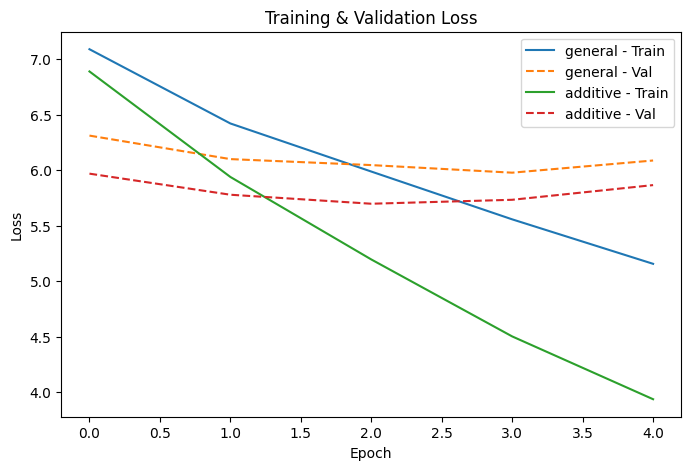

In [43]:
# =========================
# LOSS CURVES
# =========================
plt.figure(figsize=(8, 5))
for attn_type in results:
    plt.plot(results[attn_type]['train_loss'], label=f"{attn_type} - Train")
    plt.plot(results[attn_type]['val_loss'], linestyle='--', label=f"{attn_type} - Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

In [47]:
# =========================
# ATTENTION VISUALIZATION
# =========================
def translate_sentence(model, sentence, max_len=50):
    model.eval()
    tokens = tokenize(sentence)
    src_idxs = [2] + en_vocab.encode(tokens) + [3]  # <sos>, <eos>

    src_tensor = torch.tensor(src_idxs).unsqueeze(1).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_idxs = [2]  # <sos>
    attentions = []

    for _ in range(max_len):
        trg_tensor = torch.tensor([trg_idxs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, attn = model.decoder(
                trg_tensor, hidden, encoder_outputs
            )

        pred_token = output.argmax(1).item()
        trg_idxs.append(pred_token)
        attentions.append(attn.cpu().numpy())

        if pred_token == 3:  # <eos>
            break

    return trg_idxs, np.array(attentions).squeeze(1)


In [48]:
def plot_attention(src_sentence, trg_tokens, attentions):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    src_tokens = ['<sos>'] + tokenize(src_sentence) + ['<eos>']
    trg_tokens = [ne_vocab.itos[t] for t in trg_tokens]

    ax.set_xticks(range(len(src_tokens)))
    ax.set_yticks(range(len(trg_tokens)))

    ax.set_xticklabels(src_tokens, rotation=90)
    ax.set_yticklabels(trg_tokens)

    ax.set_xlabel("Source Sentence")
    ax.set_ylabel("Generated Translation")
    plt.show()

Input : how are you
Output: के तपाईँ कसरी बसिरहेका


/Users/prabidhi/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/prabidhi/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/prabidhi/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/prabidhi/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/prabidhi/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2346 (\N{DEVANAGAR

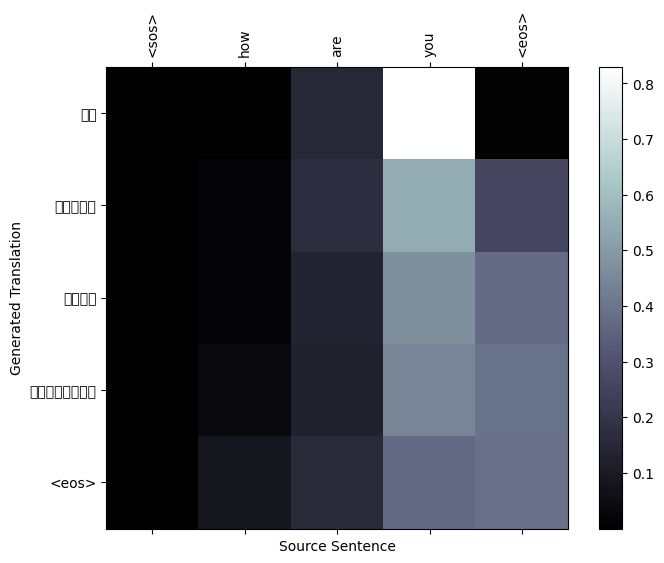

In [ ]:
# =========================
# EXAMPLE ATTENTION MAP
# =========================
example_sentence = "how are you"

best_model = results['additive']['model']
trg_tokens, attentions = translate_sentence(best_model, example_sentence)

translation = [ne_vocab.itos[t] for t in trg_tokens[1:-1]]
print("Input :", example_sentence)
print("Output:", " ".join(translation))

plot_attention(example_sentence, trg_tokens[1:], attentions)

In [54]:
torch.save(
    results['additive']['model'].state_dict(),
    "app/additive_model.pt"
)